In [1]:
import numpy as np
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
def write_and_print(file, text):
    file.write(text)
    print(text)

['seed: 2', 'data: fmnist', 'epochs: 5', 'epochs_hold: 5', 'hold_rate: 0.995', 'runs: 5', 'num_members: 5']


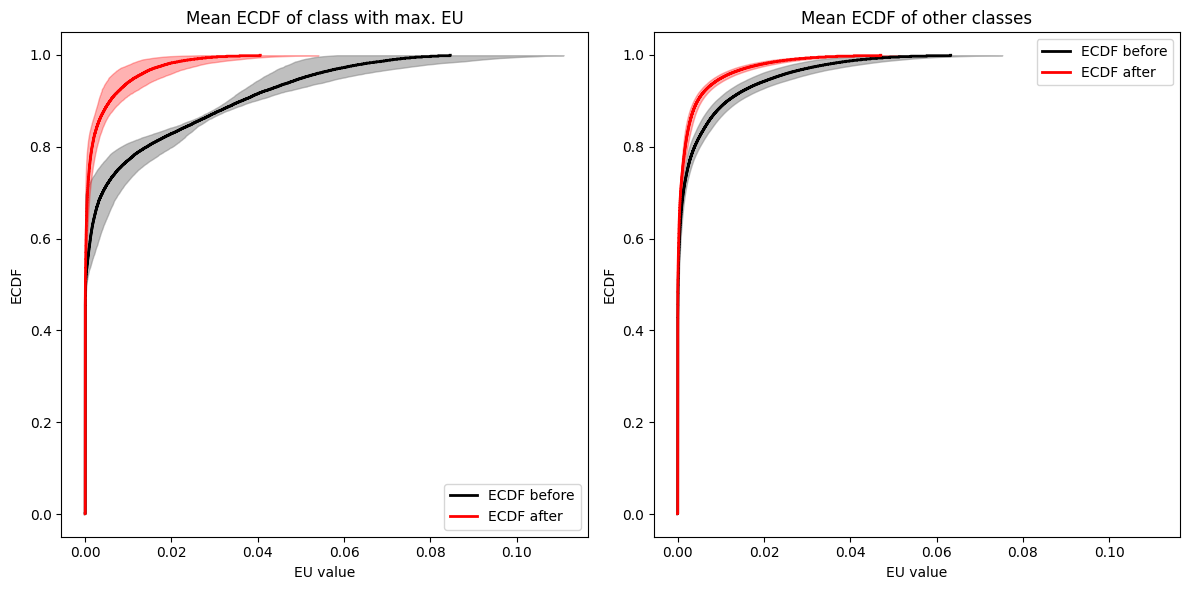

     Max_EU class,    Other classes,   Next highest drop


Abs: 0.0070±0.0006,   0.0018±0.0000,   0.0029±0.0000

Rel: 0.7934±0.0616,   0.3872±0.0000,   0.5619±0.0000


['seed: 2', 'data: cifar', 'epochs: 20', 'epochs_hold: 20', 'hold_rate: 0.9', 'runs: 5', 'num_members: 5']


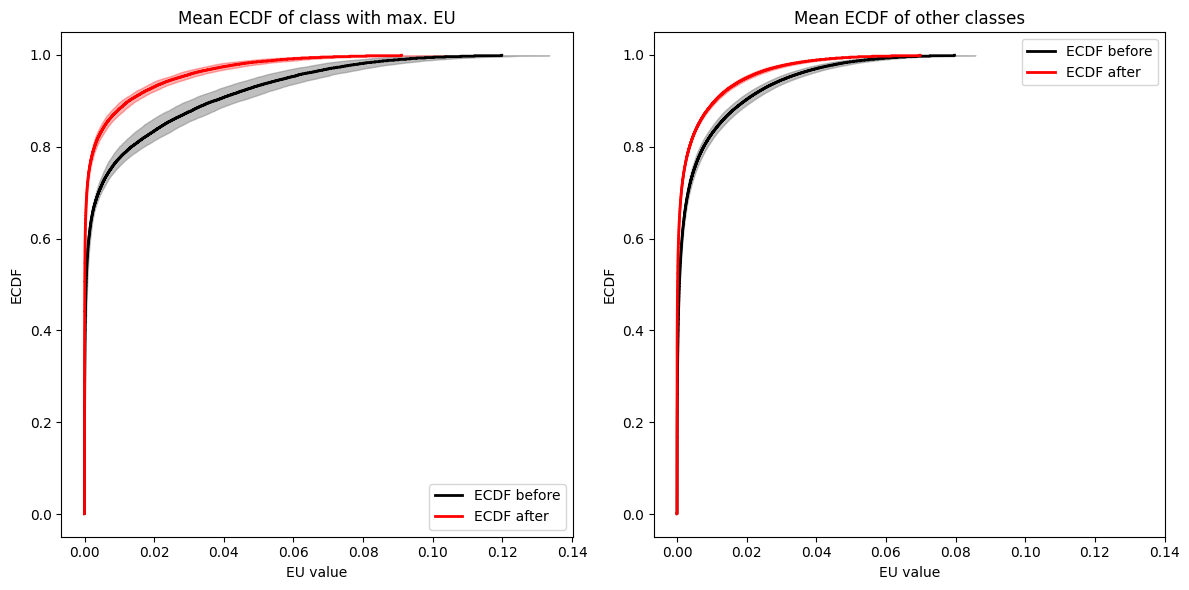

     Max_EU class,    Other classes,   Next highest drop


Abs: 0.0057±0.0011,   0.0023±0.0000,   0.0031±0.0000

Rel: 0.5815±0.0304,   0.3682±0.0000,   0.4630±0.0000




In [5]:
for name in ['fmnist', 'cifar']:
    data = np.load(f'results/results_{name}.npz')
    out = []
    for key in data.keys():
        if key not in ['eus_after', 'eus_before']:
            out.append(f'{key}: {data[key]}')
    print(out)
    eus_before = data['eus_before']
    eus_after = data['eus_after']
    ind_max = np.argmax(eus_before.mean(1),-1)
    eus_before_max = eus_before[np.arange(eus_before.shape[0]),:,ind_max]
    eus_after_max = eus_after[np.arange(eus_after.shape[0]),:,ind_max]
    mask = np.ones(eus_before.shape, dtype=bool)
    np.put_along_axis(mask, ind_max[:,None,None], False, -1)
    eus_before_other = eus_before[mask].reshape(mask.shape[0], mask.shape[1],mask.shape[2]-1)
    eus_after_other = eus_after[mask].reshape(mask.shape[0], mask.shape[1],mask.shape[2]-1)

    n = 1000
    quants = np.arange(n)[1:]/n
    xs_before = np.quantile(eus_before_max, quants, -1, method='inverted_cdf').T
    xs_after = np.quantile(eus_after_max, quants, -1, method='inverted_cdf').T

    xs_before_other = np.quantile(eus_before_other, quants, 1, method='inverted_cdf').mean(-1).T
    xs_after_other = np.quantile(eus_after_other, quants, 1, method='inverted_cdf').mean(-1).T

    x_mean_before, x_std_before = xs_before.mean(0), xs_before.std(0)
    x_mean_after, x_std_after = xs_after.mean(0), xs_after.std(0)

    x_mean_before_other, x_std_before_other = xs_before_other.mean(0), xs_before_other.std(0)
    x_mean_after_other, x_std_after_other = xs_after_other.mean(0), xs_after_other.std(0)
    # for x in xs_before:
    #     plt.step(x, quants, where='post', label='ECDF')
    # for x in xs_after:
    #     plt.step(x, quants, where='post', label='ECDF_after')
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first set of ECDFs on ax1
    ax1.step(x_mean_before, quants, where='post', label='ECDF before', linewidth=2, color='black')
    ax1.fill_betweenx(quants, np.clip(x_mean_before - x_std_before, 0, 100), x_mean_before + x_std_before, color='gray', alpha=0.5)
    ax1.step(x_mean_after, quants, where='post', label='ECDF after', linewidth=2, color='red')
    ax1.fill_betweenx(quants, np.clip(x_mean_after- x_std_after, 0, 100), x_mean_after + x_std_after, color='red', alpha=0.3)
    ax1.set_title('Mean ECDF of class with max. EU')
    ax1.set_xlabel('EU value')
    ax1.set_ylabel('ECDF')
    ax1.legend()
    # Plot for the second set of ECDFs on ax2
    ax2.step(x_mean_before_other, quants, where='post', label='ECDF before', linewidth=2, color='black')
    ax2.fill_betweenx(quants, x_mean_before_other - x_std_before_other, x_mean_before_other + x_std_before_other, color='gray', alpha=0.5)
    ax2.step(x_mean_after_other, quants, where='post', label='ECDF after', linewidth=2, color='red')
    ax2.fill_betweenx(quants, x_mean_after_other - x_std_after_other, x_mean_after_other + x_std_after_other, color='red', alpha=0.3)
    ax2.set_title('Mean ECDF of other classes')
    ax2.set_xlabel('EU value')
    ax2.set_ylabel('ECDF')
    ax2.set_xlim(ax1.get_xlim())
    ax2.legend()
    plt.tight_layout()
    plt.show()
    abs_max_eu = (eus_before_max.mean(-1) - eus_after_max.mean(-1))
    abs_other = (eus_before_other.mean(1) - eus_after_other.mean(1)).mean(-1)
    rel_max_eu = 1-(eus_after_max.mean(-1)/eus_before_max.mean(-1))
    rel_other = (1-(eus_after_other.mean(1)/eus_before_other.mean(1))).mean(-1)
    with open(f'results/results_{name}.txt', 'w') as text_file:
        write_and_print(text_file,'     Max_EU class,    Other classes,   Next highest drop\n\n')
        write_and_print(text_file,f'Abs: {abs_max_eu.mean():.4f}±{abs_max_eu.std():.4f},   {abs_other.mean(-1).mean():.4f}±{abs_other.mean(-1).std():.4f},   {abs_other.max(-1).mean():.4f}±{abs_other.max(-1).std():.4f}\n')
        write_and_print(text_file,f'Rel: {rel_max_eu.mean():.4f}±{rel_max_eu.std():.4f},   {rel_other.mean(-1).mean():.4f}±{rel_other.mean(-1).std():.4f},   {rel_other.max(-1).mean():.4f}±{rel_other.max(-1).std():.4f}')
    print('\n')

